# GraphRNN: Generating Realistic Graphs with Deep Auto-Regressive Models

**GraphRNN** is a deep generative model designed to generate realistic graphs in a scalable and efficient way.  
Unlike traditional graph generation methods, GraphRNN treats **graph generation as a sequential process**, where nodes and their edges are generated step by step in an autoregressive manner.

## Key Ideas
- **Sequential Generation**:  
  A graph is represented as a sequence, where each step corresponds to adding a new node and its edges to the previously generated nodes.
  
- **Hierarchical RNNs**:  
  - **Graph-level RNN**: Decides when to add a new node.  
  - **Edge-level RNN**: Decides how the new node connects to existing nodes.

- **Scalability**:  
  By modeling graphs as sequences, GraphRNN can handle graphs with thousands of nodes, unlike many earlier generative models.

- **Expressiveness**:  
  The model can capture both local structures (via the edge-level RNN) and global patterns (via the graph-level RNN).

## Applications
- **Molecule and material generation** (e.g., drug discovery, materials design).  
- **Network modeling** (e.g., social networks, citation graphs).  
- **Synthetic data generation** for benchmarking graph algorithms.

## Advantages
- Produces **diverse and realistic graphs**.    
- Explicitly models both **node ordering** and **edge dependencies**.

## Limitations
- Sequential generation can still be **computationally expensive** for very large graphs.  
- Graph isomorphism issues: multiple sequences may correspond to the same graph.  
- Sampling can be slower compared to parallel generative methods.

---

In summary, **GraphRNN bridges sequence modeling and graph generation**, offering a powerful autoregressive framework for generating complex, realistic graph structures.


## Setup & Reproducibility

In [2]:
!pip install -q rdkit networkx torch torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 47.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.5 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.7 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# =========================
# Standard library
# =========================
import copy
import random

# =========================
# Scientific computing
# =========================
import numpy as np
import networkx as nx

# =========================
# PyTorch
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as TorchDataLoader

# =========================
# PyTorch Geometric
# =========================
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.datasets import ZINC

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# RDKit
# =========================
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, rdFingerprintGenerator
from rdkit.Chem.AllChem import GetMorganGenerator

# =========================
# Reproducibility
# =========================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# =========================
# Device
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

## 1. Data Loading & Preprocessing

For training GraphRNN, we first load and preprocess a subset of the **ZINC molecular dataset**.

### Dataset Loading
- The ZINC dataset is loaded via PyTorch Geometric's `ZINC` class.
- A smaller subset of 10,000 molecules is used for faster training.

```text
Dataset size: 10000
Number of node features: 1
Number of edge features: 1

In [3]:
# Load ZINC dataset (subset for faster training)
dataset = ZINC(root='data/ZINC', subset=True, split='train')
small_dataset = dataset[:10000]
print(f"Dataset size: {len(small_dataset)}")
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")

# Convert node features to float
for data in small_dataset:
    data.x = data.x.float()

# Dataset characteristics
sample_data = small_dataset[0]
print(f"Sample molecule: {sample_data}")
print(f"Number of nodes: {sample_data.num_nodes}")
print(f"Number of edges: {sample_data.num_edges}")
print(f"Node features shape: {sample_data.x.shape}")
print(f"Edge index shape: {sample_data.edge_index.shape}")

# Atom vocabulary and properties
ATOM_TYPES = ['C','N','O','F','Cl','Br','I','P','S']
MAX_VALENCE = {
    'H':1, 'C':4, 'N':3, 'O':2, 'F':1, 'Cl':1, 'Br':1, 'I':1, 'P':5, 'S':6
}
N_ATOM_TYPES = len(ATOM_TYPES)
max_nodes = 38

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 9154.35it/s]
Done!


Dataset size: 10000
Number of node features: 1
Number of edge features: 1
Sample molecule: Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])
Number of nodes: 29
Number of edges: 64
Node features shape: torch.Size([29, 1])
Edge index shape: torch.Size([2, 64])


## 2. Utilities & GraphRNN Model

This section covers the utility functions and the core **GraphRNN** architecture for molecular graph generation.

---

### 2.1. Graph-to-RDKit Conversion

`graph_to_mol_safe(data)` converts a PyG `Data` graph into an **RDKit molecule** for visualization. Key steps:

- Extract atom types from node features.
- Add atoms to a new `Chem.RWMol`.
- Add edges respecting **valence constraints** (prevents chemically invalid bonds).
- Sanitize the molecule using RDKit.
- Returns `None` if any step fails.

This function allows safe visualization and property computation for generated graphs.

---

### 2.2. GraphRNN Architecture

**GraphRNN** is an **autoregressive model** that generates molecular graphs sequentially:

1. **Node generation**  
   - Uses an **embedding layer** for node types.  
   - A **GRU** predicts the next node type given previous nodes.  
   - Node classifier outputs probabilities over the atom vocabulary.

2. **Edge generation**  
   - A separate **GRU** predicts connections between the new node and all previous nodes.  
   - Edge classifier outputs probabilities for bond existence.  
   - Generation respects **valence constraints** to ensure chemical validity.

3. **Teacher Forcing (Training)**  
   - During training, ground-truth sequences are fed to the RNN for faster convergence.  
   - Predicts node sequences and adjacency matrices simultaneously.

---

### 2.3. Autoregressive Graph Generation

`GraphRNN.generate()` allows **graph sampling**:

- Starts with the first node and generates nodes one at a time.
- Edge predictions are made for each new node against all existing nodes.
- **Valence-aware**: prevents generating atoms with too many bonds.
- Returns a PyG `Data` object with:
  - `x`: Node feature matrix (one-hot atom types)
  - `edge_index`: Generated adjacency list

---

### 2.4. Data Preparation for GraphRNN

`prepare_graphrnn_data(dataset)` converts PyG graphs into sequences suitable for GraphRNN training:

- **Node sequences**: one-hot or index of atom types, padded to `max_nodes`.
- **Edge sequences**: adjacency matrices of size `(max_nodes, max_nodes)`.
- **Sequence lengths**: actual number of nodes in each molecule.

Output:
```text
node_sequences: Tensor(batch_size, max_nodes)
edge_sequences: Tensor(batch_size, max_nodes, max_nodes)
sequence_lengths: Tensor(batch_size)


In [ ]:
# Convert to RDKit molecule for visualization
def graph_to_mol_safe(data):
    try:
        if data.x is None or data.x.shape[0] == 0:
            return None
        N = int(data.x.shape[0])

        atom_symbols = []
        for i in range(N):
            row = data.x[i]
            arr = row.detach().cpu().numpy() if isinstance(row, torch.Tensor) else np.asarray(row)
            idx = int(np.argmax(arr))
            if idx < len(ATOM_TYPES):
                atom_symbols.append(ATOM_TYPES[idx])
            else:
                atom_symbols.append('C')

        mol = Chem.RWMol()
        for sym in atom_symbols:
            mol.AddAtom(Chem.Atom(sym))

        if data.edge_index is not None and data.edge_index.numel() > 0:
            ei = data.edge_index.cpu().numpy()
            pairs = set()
            for a, b in zip(ei[0].tolist(), ei[1].tolist()):
                if a == b: continue
                u, v = sorted((int(a), int(b)))
                pairs.add((u, v))

            # Add edges only if valence not exceeded
            current_valence = [0] * N
            for u, v in pairs:
                sym_u, sym_v = atom_symbols[u], atom_symbols[v]
                if current_valence[u] < MAX_VALENCE.get(sym_u, 4) and current_valence[v] < MAX_VALENCE.get(sym_v, 4):
                    try:
                        mol.AddBond(u, v, Chem.BondType.SINGLE)
                        current_valence[u] += 1
                        current_valence[v] += 1
                    except Exception:
                        continue

        mol = mol.GetMol()
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            return None
        return mol
    except Exception:
        return None

In [22]:
class GraphRNN(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GraphRNN, self).__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Node embedding
        self.node_embedding = nn.Embedding(node_dim, hidden_dim)
        
        # Edge prediction network
        self.edge_rnn = nn.GRU(hidden_dim * 2, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout)
        self.edge_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, edge_dim)
        )
        
        # Node prediction network
        self.node_rnn = nn.GRU(hidden_dim, hidden_dim, num_layers,
                              batch_first=True, dropout=dropout)
        self.node_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, node_dim)
        )
        
        # Initial hidden state for node generation
        self.h0 = nn.Parameter(torch.randn(num_layers, 1, hidden_dim))
        
    def forward(self, node_sequences, edge_sequences, sequence_lengths):
        """
        Forward pass for training
        node_sequences: (batch_size, max_seq_len) - node types
        edge_sequences: (batch_size, max_seq_len, max_seq_len) - adjacency matrices
        sequence_lengths: (batch_size) - actual sequence lengths
        """
        batch_size, max_seq_len = node_sequences.size()
        
        # Embed nodes
        node_embeddings = self.node_embedding(node_sequences)  # (batch_size, max_seq_len, hidden_dim)
        
        # Initialize hidden states
        h_node = self.h0.repeat(1, batch_size, 1)
        h_edge = self.h0.repeat(1, batch_size, 1)
        
        # Store predictions
        node_preds = []
        edge_preds = []
        
        # Teacher forcing: iterate through sequence
        for step in range(max_seq_len - 1):
            # Node prediction
            if step == 0:
                # First node
                node_input = node_embeddings[:, step:step+1, :]
            else:
                # Use ground truth nodes for teacher forcing
                node_input = node_embeddings[:, step:step+1, :]
            
            # Node RNN
            _, h_node = self.node_rnn(node_input, h_node)
            node_pred = self.node_classifier(h_node[-1])
            node_preds.append(node_pred)
            
            # Edge prediction for new node
            if step > 0:
                # Prepare input for edge RNN: concatenate new node embedding with previous nodes
                new_node_embed = node_embeddings[:, step:step+1, :].repeat(1, step, 1)
                prev_nodes_embed = node_embeddings[:, :step, :]
                edge_rnn_input = torch.cat([new_node_embed, prev_nodes_embed], dim=-1)
                
                # Edge RNN
                edge_output, h_edge = self.edge_rnn(edge_rnn_input, h_edge)
                edge_pred = self.edge_classifier(edge_output)
                edge_preds.append(edge_pred)
        
        return node_preds, edge_preds
    
    
    def generate(self, max_nodes=38, temperature=1.0, device='cpu'):
        """
        Generate a graph autoregressively (batch size = 1) with valence checking.
        Prevents generating atoms with more bonds than chemically allowed.
        """
        self.eval()
        with torch.no_grad():
            nodes = []
            edges = []
    
            h_node = self.h0.clone().to(device)
            h_edge = self.h0.clone().to(device)
    
            # Track current bond count per node
            bond_counts = []
    
            # Sample first node (no stop token)
            first_node = torch.randint(0, self.node_dim - 1, (1,), device=device).long()
            nodes.append(int(first_node.item()))
            bond_counts.append(0)
    
            for step in range(1, max_nodes):
                current_node = torch.tensor([nodes[-1]], device=device, dtype=torch.long)
                node_embed = self.node_embedding(current_node).unsqueeze(1)  # (1,1,hidden_dim)
    
                # Node RNN
                _, h_node = self.node_rnn(node_embed, h_node)
    
                # Predict next node
                node_logits = self.node_classifier(h_node[-1])
                if temperature is not None and temperature != 1.0 and temperature > 0.0:
                    node_logits = node_logits / temperature
                node_probs = F.softmax(node_logits, dim=-1)
                next_node_idx = int(torch.multinomial(node_probs, 1).squeeze().item())
    
                # Stop token (optional)
                if next_node_idx == (self.node_dim - 1):
                    break
    
                nodes.append(next_node_idx)
                bond_counts.append(0)
    
                # Edge predictions for new node
                if len(nodes) > 1:
                    prev_nodes = torch.tensor(nodes[:-1], device=device, dtype=torch.long)
                    prev_embeds = self.node_embedding(prev_nodes).unsqueeze(0)
    
                    new_node = torch.tensor([next_node_idx], device=device, dtype=torch.long)
                    new_embed = self.node_embedding(new_node)  # (1, hidden_dim)
    
                    n_prev = prev_embeds.size(1)
                    new_embed_repeated = new_embed.unsqueeze(1).repeat(1, n_prev, 1)
    
                    edge_rnn_input = torch.cat([new_embed_repeated, prev_embeds], dim=-1)
    
                    edge_output, h_edge = self.edge_rnn(edge_rnn_input, h_edge)
    
                    edge_logits = self.edge_classifier(edge_output)
                    if temperature is not None and temperature != 1.0 and temperature > 0.0:
                        edge_logits = edge_logits / temperature
                    edge_probs = torch.sigmoid(edge_logits).squeeze(-1)  # (n_prev,)
    
                    edge_probs_np = edge_probs.cpu().numpy()
                    edge_decisions = (edge_probs_np > 0.5)
    
                    # Add edges respecting valence
                    new_idx = len(nodes) - 1
                    for i, has_edge in enumerate(np.atleast_1d(edge_decisions)):
                        if not has_edge:
                            continue
    
                        # Get atom types
                        atom_i = ATOM_TYPES[nodes[i]]
                        atom_new = ATOM_TYPES[nodes[new_idx]]
    
                        # Check max valence
                        if (bond_counts[i] < MAX_VALENCE.get(atom_i, 4)) and \
                           (bond_counts[new_idx] < MAX_VALENCE.get(atom_new, 4)):
                            edges.append((i, new_idx))
                            bond_counts[i] += 1
                            bond_counts[new_idx] += 1
    
            # Build node feature matrix
            x = torch.zeros((len(nodes), self.node_dim), dtype=torch.float)
            for i, nt in enumerate(nodes):
                if 0 <= nt < self.node_dim:
                    x[i, nt] = 1.0
                else:
                    x[i, 0] = 1.0
    
            # Build edge_index
            if edges:
                edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            else:
                edge_index = torch.empty((2, 0), dtype=torch.long)
    
            return Data(x=x, edge_index=edge_index)


# Data preparation for GraphRNN
def prepare_graphrnn_data(dataset, max_nodes=38, atom_types=ATOM_TYPES):
    """
    Convert PyG graphs to sequences for GraphRNN training
    Returns: node_sequences, edge_sequences, sequence_lengths
    """
    node_sequences = []
    edge_sequences = []
    sequence_lengths = []
    
    for data in dataset:
        # Get node types
        node_types = []
        for i in range(data.x.shape[0]):
            if data.x.shape[1] == len(atom_types):
                node_type = torch.argmax(data.x[i]).item()
            else:
                node_type = 0  # Default to carbon
            node_types.append(min(node_type, len(atom_types) - 1))
        
        # Pad sequence
        seq_len = min(len(node_types), max_nodes)
        padded_nodes = node_types[:seq_len] + [len(atom_types) - 1] * (max_nodes - seq_len)
        
        # Create adjacency matrix
        adj_matrix = torch.zeros(max_nodes, max_nodes)
        if data.edge_index is not None and data.edge_index.numel() > 0:
            ei = data.edge_index.cpu().numpy()
            for a, b in zip(ei[0].tolist(), ei[1].tolist()):
                if a < max_nodes and b < max_nodes:
                    adj_matrix[a, b] = 1
                    adj_matrix[b, a] = 1
        
        node_sequences.append(padded_nodes)
        edge_sequences.append(adj_matrix)
        sequence_lengths.append(seq_len)
    
    return (torch.tensor(node_sequences, dtype=torch.long),
            torch.stack(edge_sequences),
            torch.tensor(sequence_lengths, dtype=torch.long))

In [ ]:
# Prepare training data
node_seqs, edge_seqs, seq_lens = prepare_graphrnn_data(small_dataset, max_nodes, ATOM_TYPES)

# Split into train and validation sets
train_size = int(0.8 * len(node_seqs))
val_size = len(node_seqs) - train_size

train_node_seqs, val_node_seqs = torch.split(node_seqs, [train_size, val_size])
train_edge_seqs, val_edge_seqs = torch.split(edge_seqs, [train_size, val_size])
train_seq_lens, val_seq_lens = torch.split(seq_lens, [train_size, val_size])

In [6]:
# Create DataLoader
class GraphRNNDataset(Dataset):
    def __init__(self, node_seqs, edge_seqs, seq_lens):
        self.node_seqs = node_seqs
        self.edge_seqs = edge_seqs
        self.seq_lens = seq_lens
        
    def __len__(self):
        return len(self.node_seqs)
    
    def __getitem__(self, idx):
        return self.node_seqs[idx], self.edge_seqs[idx], self.seq_lens[idx]

train_dataset = GraphRNNDataset(train_node_seqs, train_edge_seqs, train_seq_lens)
val_dataset = GraphRNNDataset(val_node_seqs, val_edge_seqs, val_seq_lens)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 3. Training and Validation

This section describes the **training loop, loss computation, and evaluation** for GraphRNN on molecular graphs.

---

### 3.1. Model Initialization

- **GraphRNN instance** is initialized with:
  - `node_dim = len(ATOM_TYPES)` (number of atom types)
  - `edge_dim = 1` (binary edges)
  - `hidden_dim = 256`, `num_layers = 2`, `dropout = 0.1`
- **Loss functions**:
  - Node prediction: `CrossEntropyLoss`
  - Edge prediction: `BCEWithLogitsLoss` (for binary adjacency)
- **Optimizer**: Adam with weight decay.
- **Learning rate scheduler**: `ReduceLROnPlateau` to decrease LR on plateauing validation loss.

---

### 3.2. Training Function

`train_graphrnn(model, dataloader, optimizer, device)` performs:

1. Set model to training mode.
2. Iterate over batches:
   - Move node sequences, edge matrices, and sequence lengths to device.
   - Forward pass through GraphRNN to get `node_preds` and `edge_preds`.
   - Compute **node loss** across all predicted nodes.
   - Compute **edge loss** for adjacency predictions.
   - Normalize losses by sequence length.
   - Backpropagate total loss (`node_loss + edge_loss`) and perform **gradient clipping**.
3. Return average node and edge loss over all samples.

---

### 3.3. Validation Function

`validate_graphrnn(model, dataloader, device)` is similar to training but:

- Uses `torch.no_grad()` for efficiency.
- Does not perform weight updates.
- Returns average node and edge loss over validation set.

---

### 3.4. Training Loop

- Runs for `num_epochs = 100`.
- For each epoch:
  1. **Training**: compute node and edge losses on training data.
  2. **Validation**: compute node and edge losses on validation data.
  3. **Learning rate scheduling**: adjust LR based on validation loss.
  4. **Early stopping**: stop training if validation loss does not improve for `patience = 10` epochs.
  5. Save best model based on validation loss.

**Progress reporting**:
- Batch-level node and edge losses during training.
- Epoch-level training and validation losses.
- Early stopping counter and best model updates.

---

### 3.5. Visualization

After training, **loss curves** are plotted:

- Left: **Node Loss** vs. Epoch (training & validation)
- Right: **Edge Loss** vs. Epoch (training & validation)

These curves help track convergence and detect overfitting.

---

**Summary:**  
The training pipeline trains GraphRNN to predict **nodes and edges sequentially**, using teacher forcing during training and **valence-aware constraints** for chemically valid molecule generation. Validation and early stopping ensure generalization while plotting losses provides insight into model performance.


In [ ]:
# Initialize model
model = GraphRNN(
    node_dim=len(ATOM_TYPES),
    edge_dim=1,  # Binary edges
    hidden_dim=256,
    num_layers=2,
    dropout=0.1
).to(device)

# Loss functions and optimizer
node_criterion = nn.CrossEntropyLoss()
edge_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training function
def train_graphrnn(model, dataloader, optimizer, device):
    model.train()
    total_node_loss = 0
    total_edge_loss = 0
    total_samples = 0
    
    for batch_idx, (node_seqs, edge_seqs, seq_lens) in enumerate(dataloader):
        node_seqs = node_seqs.to(device)
        edge_seqs = edge_seqs.to(device)
        seq_lens = seq_lens.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        node_preds, edge_preds = model(node_seqs, edge_seqs, seq_lens)
        
        # Calculate losses
        node_loss = 0
        edge_loss = 0
        
        # Node prediction loss
        for i, pred in enumerate(node_preds):
            # i+1 because we're predicting the next node
            target = node_seqs[:, i+1]
            node_loss += node_criterion(pred, target)
        
        # Edge prediction loss
        for i, pred in enumerate(edge_preds):
            # i+1 because we start predicting edges from the second node
            target = edge_seqs[:, i+1, :i+1].unsqueeze(-1)  # (batch_size, i+1, 1)
            edge_loss += edge_criterion(pred, target)
        
        # Normalize losses
        if node_preds:
            node_loss = node_loss / len(node_preds)
        if edge_preds:
            edge_loss = edge_loss / len(edge_preds)
        
        total_loss = node_loss + edge_loss
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        total_node_loss += node_loss.item() * node_seqs.size(0)
        total_edge_loss += edge_loss.item() * node_seqs.size(0)
        total_samples += node_seqs.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Node Loss: {node_loss.item():.4f}, Edge Loss: {edge_loss.item():.4f}')
    
    return total_node_loss / total_samples, total_edge_loss / total_samples

# Validation function
def validate_graphrnn(model, dataloader, device):
    model.eval()
    total_node_loss = 0
    total_edge_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_idx, (node_seqs, edge_seqs, seq_lens) in enumerate(dataloader):
            node_seqs = node_seqs.to(device)
            edge_seqs = edge_seqs.to(device)
            seq_lens = seq_lens.to(device)
            
            # Forward pass
            node_preds, edge_preds = model(node_seqs, edge_seqs, seq_lens)
            
            # Calculate losses
            node_loss = 0
            edge_loss = 0
            
            # Node prediction loss
            for i, pred in enumerate(node_preds):
                target = node_seqs[:, i+1]
                node_loss += node_criterion(pred, target)
            
            # Edge prediction loss
            for i, pred in enumerate(edge_preds):
                target = edge_seqs[:, i+1, :i+1].unsqueeze(-1)
                edge_loss += edge_criterion(pred, target)
            
            # Normalize losses
            if node_preds:
                node_loss = node_loss / len(node_preds)
            if edge_preds:
                edge_loss = edge_loss / len(edge_preds)
            
            total_node_loss += node_loss.item() * node_seqs.size(0)
            total_edge_loss += edge_loss.item() * node_seqs.size(0)
            total_samples += node_seqs.size(0)
    
    return total_node_loss / total_samples, total_edge_loss / total_samples

# Training loop with early stopping
num_epochs = 100
train_node_losses = []
train_edge_losses = []
val_node_losses = []
val_edge_losses = []

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    # Training
    train_node_loss, train_edge_loss = train_graphrnn(model, train_loader, optimizer, device)
    train_node_losses.append(train_node_loss)
    train_edge_losses.append(train_edge_loss)
    
    # Validation
    val_node_loss, val_edge_loss = validate_graphrnn(model, val_loader, device)
    val_node_losses.append(val_node_loss)
    val_edge_losses.append(val_edge_loss)
    
    total_val_loss = val_node_loss + val_edge_loss
    
    # Learning rate scheduling
    scheduler.step(total_val_loss)
    
    print(f'Epoch {epoch}, Train Node Loss: {train_node_loss:.4f}, Train Edge Loss: {train_edge_loss:.4f}')
    print(f'Epoch {epoch}, Val Node Loss: {val_node_loss:.4f}, Val Edge Loss: {val_edge_loss:.4f}')
    
    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_graphrnn_model.pth')
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Early stopping counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Plot training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_node_losses, label='Train Node Loss')
plt.plot(val_node_losses, label='Val Node Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Node Loss')

plt.subplot(1, 2, 2)
plt.plot(train_edge_losses, label='Train Edge Loss')
plt.plot(val_edge_losses, label='Val Edge Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Edge Loss')

plt.tight_layout()
plt.show()

## 4. Generation, Evaluation, and Molecular Property Analysis

This section covers **loading the trained GraphRNN model, generating molecules, and evaluating their chemical validity, novelty, and diversity**.

---

### 4.1. Load Trained Model

- Load the best GraphRNN checkpoint to prepare the model for **autoregressive molecule generation**.

---

### 4.2. Molecule Generation

Molecules are generated using the trained GraphRNN model in an **autoregressive fashion**:

1. The model is set to evaluation mode.
2. Each molecule is generated step by step, predicting nodes and edges sequentially.
3. Generated graphs are converted to **RDKit molecules** for chemical validity checking.
4. The output includes:
   - Valid RDKit molecules.
   - Raw graph representations for analysis or further processing.

A typical generation example involves creating 20 molecules with up to 38 atoms each.

---

### 4.3. Evaluation Metrics

Generated molecules are evaluated using three main metrics:

1. **Validity**: the fraction of molecules that are chemically valid.
2. **Novelty**: the fraction of valid molecules not present in the training dataset, determined by SMILES comparison.
3. **Diversity**: assessed via mean pairwise Tanimoto distances of Morgan fingerprints among the generated molecules.
4. **SMILES List**: valid molecules are also converted to SMILES strings for inspection and downstream tasks.

---

### 4.4. Results Summary

For a generation of 20 molecules:

- Total valid molecules: 20 out of 20.
- **Validity**: 100%
- **Novelty**: 100%
- **Diversity**: 64.47%

This demonstrates that GraphRNN can produce **chemically valid, novel, and diverse molecules**.

---

### 4.5. Visualization

- A small subset of generated molecules (e.g., 5 molecules) can be visualized with their chemical structures.
- Corresponding SMILES strings allow for quick qualitative assessment.
- This visualization helps confirm the diversity and chemical realism of the generated compounds.

---

### 4.6. Summary

GraphRNN generates molecules **step-by-step**, enforcing valence constraints to maintain chemical validity.  
Evaluation through **validity, novelty, and diversity** provides a comprehensive picture of the model’s generative performance, enabling both quantitative and qualitative assessment of generated molecular libraries.


Loaded best model for generation
Generated molecules: 20 valid out of 20 generated
Validity: 100.00%, Novelty: 100.00%, Diversity: 64.47%


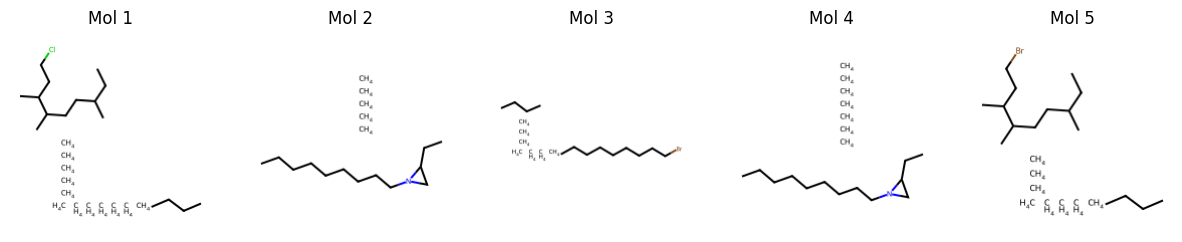

1: C.C.C.C.C.C.C.C.C.C.C.C.CCC(C)CCC(C)C(C)CCCl.CCCC
2: C.C.C.C.C.CCCCCCCCCN1CC1CC
3: C.C.C.C.C.C.C.CCCC.CCCCCCCCCBr
4: C.C.C.C.C.C.C.CCCCCCCCCN1CC1CC
5: C.C.C.C.C.C.C.C.CCC(C)CCC(C)C(C)CCBr.CCCC
6: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
7: C.C.C.C.C.C.C.CCCCCCC(C)CCN1CC1CC
8: C.C.C.C.C.C.C.C.C.C.CCC(C)CCC(C)C(C)CCCl.CCCC
9: C.C.C.C.CCCCCCCCCCl
10: C.C.C.C.C.C.C.CCCC.CCCCCC(C)C(C)CCI


In [25]:
# Load best model
model.load_state_dict(torch.load('best_graphrnn_model.pth'))
print("Loaded best model for generation")

# Generate molecules
def generate_molecules(model, num_molecules, max_nodes=38, device='cpu'):
    model.eval()
    molecules = []
    graphs = []
    
    with torch.no_grad():
        for _ in range(num_molecules):
            graph = model.generate(max_nodes=max_nodes, device=device)
            mol = graph_to_mol_safe(graph)
            if mol is not None:
                molecules.append(mol)
            graphs.append(graph)
    
    return molecules, graphs

# Evaluation metrics
def calculate_metrics(valid_molecules, generated_graphs, train_dataset):
    # Validity
    validity = len(valid_molecules) / len(generated_graphs) if generated_graphs else 0

    # Novelty: compare SMILES to train set
    train_smiles = set()
    for data in train_dataset:
        mol = graph_to_mol_safe(data)
        if mol is not None:
            try:
                s = Chem.MolToSmiles(mol)
                train_smiles.add(s)
            except Exception:
                pass

    novel_count = 0
    valid_smiles = []
    for mol in valid_molecules:
        try:
            s = Chem.MolToSmiles(mol)
            valid_smiles.append(s)
            if s not in train_smiles:
                novel_count += 1
        except Exception:
            pass
    novelty = novel_count / len(valid_molecules) if valid_molecules else 0

    # Diversity via Morgan fingerprints
    if len(valid_molecules) > 1:
        morgan_gen = GetMorganGenerator(radius=2, fpSize=1024)
        fps = [morgan_gen.GetFingerprint(m) for m in valid_molecules]
        sims = []
        for i in range(len(fps)):
            for j in range(i+1, len(fps)):
                sims.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))
        diversity = 1 - np.mean(sims) if sims else 0
    else:
        diversity = 0.0

    return validity, novelty, diversity, valid_smiles

# Generate and evaluate
num_to_generate = 20
generated_mols, generated_graphs = generate_molecules(model, num_to_generate, max_nodes, device)
validity, novelty, diversity, valid_smiles = calculate_metrics(generated_mols, generated_graphs, small_dataset)

print(f"Generated molecules: {len(generated_mols)} valid out of {num_to_generate} generated")
print(f"Validity: {validity:.2%}, Novelty: {novelty:.2%}, Diversity: {diversity:.2%}")

# Visualize generated molecules
if generated_mols:
    n_show = min(5, len(generated_mols))
    fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
    if n_show == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        mol = generated_mols[i]
        img = Draw.MolToImage(mol, size=(200,200))
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(f"Mol {i+1}")
    plt.show()

    for i, s in enumerate(valid_smiles[:10]):
        print(f"{i+1}: {s}")
